In [2]:
from patchify import patchify, unpatchify
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import glob


Large image shape is:  59885568
Patches array shape is:  (2, 2, 1, 1824, 2736, 3)
Deleted 4 existing PNG files.
All patches have been saved in the 'output_patches/realimages' directory.


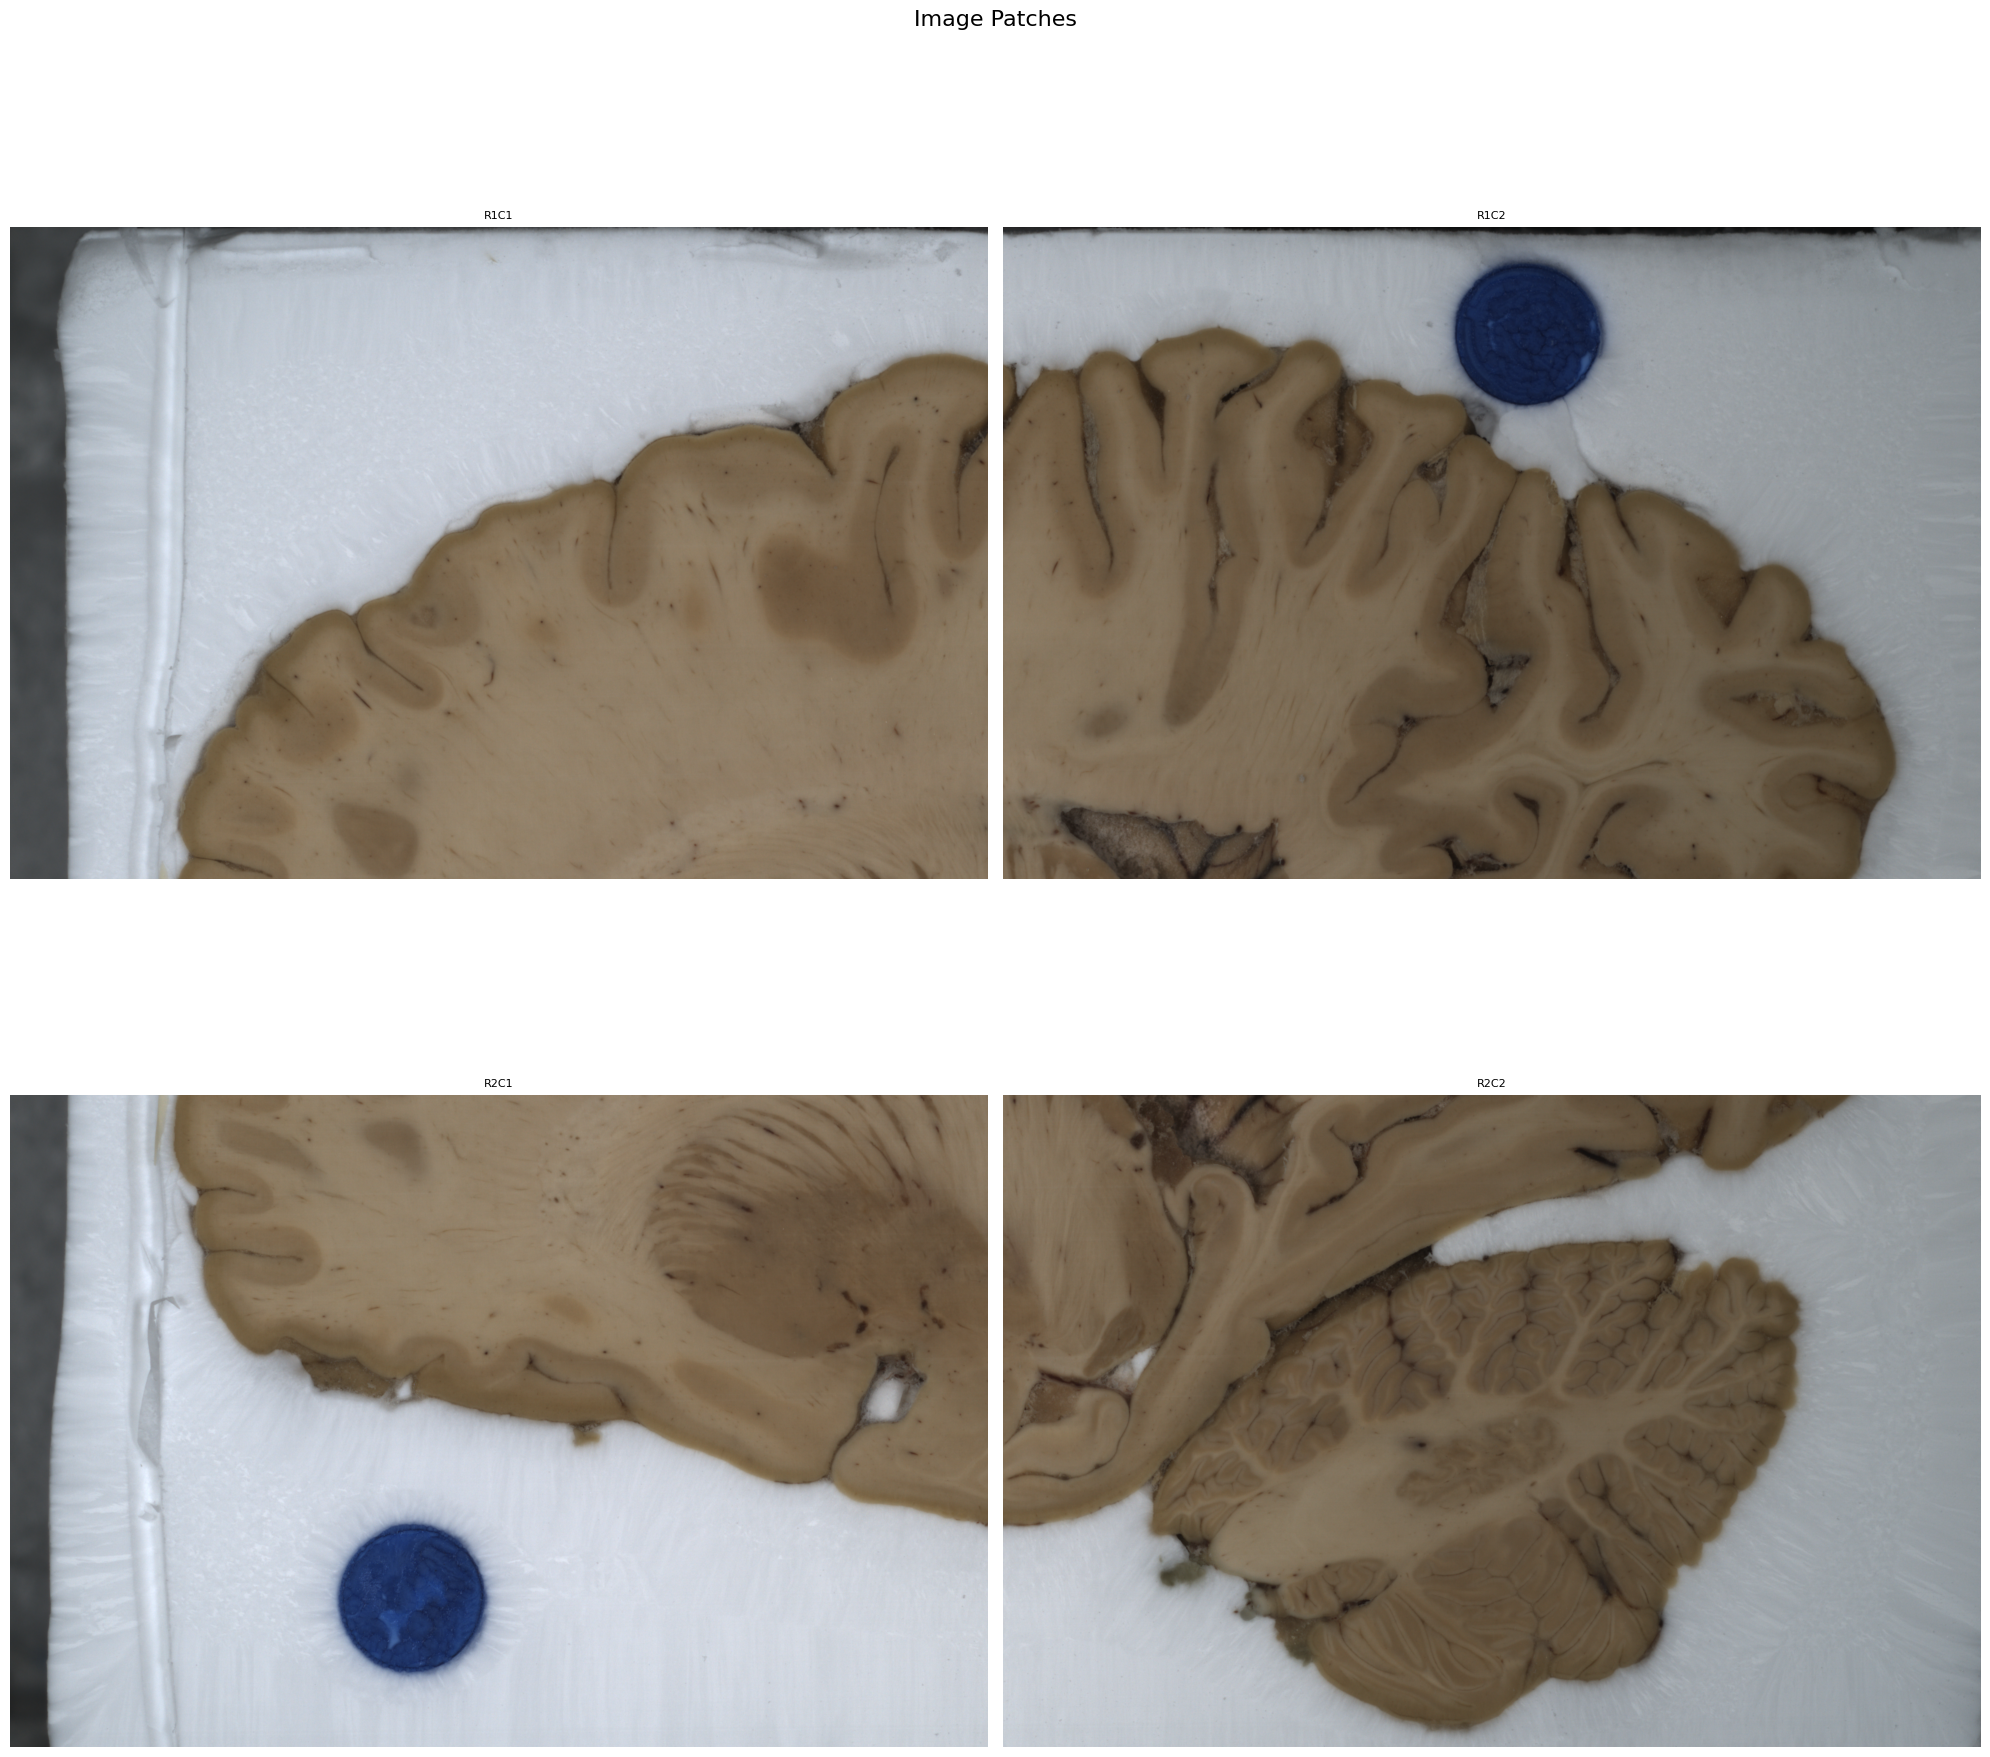

In [2]:
# Non-overlapping patches
# Read the image 
large_image = cv2.imread('dataset/test/image2/img.png', cv2.IMREAD_COLOR)
large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)
print("Large image shape is: ", large_image.size)

# Set the split factor (2 for 2x2 split)
split_factor = 2

# Determine image dimensions and patch size dynamically
if len(large_image.shape) == 3:
    height, width, channels = large_image.shape
    patch_height = height // split_factor
    patch_width = width // split_factor
    #patches = patchify(large_image, (patch_height, patch_width, channels), step=(patch_height))
    patches = patchify(large_image, (patch_height, patch_width, channels), step=(patch_height, patch_width, channels))
elif len(large_image.shape) == 2:
    height, width = large_image.shape
    patch_height = height // split_factor
    patch_width = width // split_factor
    #patches = patchify(large_image, (patch_height, patch_width), step=(patch_height))
    patches = patchify(large_image, (patch_height, patch_width), step=(patch_height, patch_width))

print("Patches array shape is: ", patches.shape)

# Create a directory to save the patches
output_dir = "output_patches/realimages"
os.makedirs(output_dir, exist_ok=True)

# Delete existing PNG files in the output directory
existing_files = glob.glob(os.path.join(output_dir, "*.png"))
for file in existing_files:
    os.remove(file)
print(f"Deleted {len(existing_files)} existing PNG files.")


# Save individual patches
for i in range(split_factor):
    for j in range(split_factor):
        if len(large_image.shape) == 3:
            patch = patches[i, j, 0, :, :, :]
        else:
            patch = patches[i, j, :, :]
        
        # Convert back to BGR for saving with cv2
        patch_bgr = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
        
        # Create a filename with row and column information
        filename = f"patch_row{i+1}_col{j+1}.png"
        filepath = os.path.join(output_dir, filename)
        
        # Save the patch
        cv2.imwrite(filepath, patch_bgr)

print(f"All patches have been saved in the '{output_dir}' directory.")

# Optionally, display a montage of the patches
fig, axes = plt.subplots(split_factor, split_factor, figsize=(20, 20))
fig.suptitle("Image Patches", fontsize=16)

for i in range(split_factor):
    for j in range(split_factor):
        if len(large_image.shape) == 3:
            patch = patches[i, j, 0, :, :, :]
        else:
            patch = patches[i, j, :, :]
        axes[i, j].imshow(patch)
        axes[i, j].axis('off')
        axes[i, j].set_title(f"R{i+1}C{j+1}", fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
# Overlapping and Non-overlapping patches

# Set the input folder containing the images
input_folder = '/mnt/g/Thesis/Registered_Exposure30/Img_TIFF'

# Set the output folder for split images
output_folder = 'output_patches/4_75_img'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Delete existing PNG files in the output directory
existing_files = glob.glob(os.path.join(output_folder, "*.png"))    
for file in existing_files:
    os.remove(file)
print(f"Deleted {len(existing_files)} existing PNG files.")

# Set the split factor (3 for 3x3 split)
split_factor = 4

# Counter for naming split images
split_counter = 1

overlap=True
overlap_percent = 0.75  # This will be used when overlap is True


def extract_patches(image, patch_size, overlap_percent):
    """Extract patches from an image with at least 50% overlap."""
    height, width, channels = image.shape
    
    # Ensure at least 50% overlap
    overlap_percent = max(overlap_percent, 0.5)
    
    # Calculate movement (step size)
    movement = int(patch_size * (1 - overlap_percent))
    
    # Ensure movement is at least 1 pixel
    movement = max(1, movement)
    
    patches = []
    
    for y in range(0, height - patch_size + 1, movement):
        for x in range(0, width - patch_size + 1, movement):
            patch = image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    
    # Add final row and column if not fully covered
    if (height - patch_size) % movement != 0:
        for x in range(0, width - patch_size + 1, movement):
            patch = image[-patch_size:, x:x + patch_size]
            patches.append(patch)
    
    if (width - patch_size) % movement != 0:
        for y in range(0, height - patch_size + 1, movement):
            patch = image[y:y + patch_size, -patch_size:]
            patches.append(patch)
    
    # Add bottom-right corner patch if not covered
    if (height - patch_size) % movement != 0 and (width - patch_size) % movement != 0:
        patch = image[-patch_size:, -patch_size:]
        patches.append(patch)
    
    return np.array(patches)

def extract_patches_with_padding(image, patch_size, movement):
    """Extract patches from an image with padding."""
    height, width, channels = image.shape
    
    # Calculate padding to ensure complete coverage of the image
    pad_height = (patch_size - height % patch_size) % patch_size
    pad_width = (patch_size - width % patch_size) % patch_size
    
    # Pad the image using reflection mode to avoid artifacts
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='reflect')
    
    # Extract patches with controlled movement from padded image
    patches = []
    
    for y in range(0, padded_image.shape[0] - patch_size + 1, movement):
        for x in range(0, padded_image.shape[1] - patch_size + 1, movement):
            patch = padded_image[y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    
    return np.array(patches)


# Process each image in the input folder
for image_path in glob.glob(os.path.join(input_folder, '*.tiff')):
    # Read the image
    large_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if large_image is None:
        print(f"Failed to read image: {os.path.basename(image_path)}")
        continue
    large_image = cv2.cvtColor(large_image, cv2.COLOR_BGR2RGB)
    print(f"Processing image: {os.path.basename(image_path)}")
    print("Image shape is: ", large_image.shape)

    # Determine image dimensions and patch size dynamically
    if overlap :
            # Determine image dimensions and patch size dynamically based on split factor
        height, width, channels = large_image.shape   
        patch_height = height // split_factor
        patch_width = width // split_factor
        movement = int(patch_height * (1 - overlap_percent))  # Calculate step size based on overlap percentage
        patches = extract_patches_with_padding(large_image, patch_height, movement)
    else:
        if len(large_image.shape) == 3:
            height, width, channels = large_image.shape
            patch_height = height // split_factor
            patch_width = width // split_factor
            patches = patchify(large_image, (patch_height, patch_width, channels), step=(patch_height, patch_width, channels))
        elif len(large_image.shape) == 2:
            height, width = large_image.shape
            patch_height = height // split_factor
            patch_width = width // split_factor
            patches = patchify(large_image, (patch_height, patch_width), step=(patch_height, patch_width))

    print("Patches array shape is: ", patches.shape, height, width, channels)
    # Calculate and print the number of patches in each direction
    total_patches = patches.shape[0]

    print(f"Total number of patches for this image: {total_patches}")
            
    if overlap:
        # Save individual patches
        for i in range(total_patches):
            patch = patches[i]
            # Convert back to BGR for saving with cv2
            patch_bgr = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
            
            # Create a filename with sequential numbering
            filename = f"splitimage{split_counter}.png"
            filepath = os.path.join(output_folder, filename)
            
            # Save the patch
            cv2.imwrite(filepath, patch_bgr)
            
            split_counter += 1
    else:
        # Save individual patches
        for i in range(split_factor):
            for j in range(split_factor):
                if len(large_image.shape) == 3:
                    patch = patches[i, j, 0, :, :, :]
                else:
                    patch = patches[i, j, :, :]
                # Convert back to BGR for saving with cv2
                patch_bgr = cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
                
                # Create a filename with sequential numbering
                filename = f"split{split_counter}.png"
                filepath = os.path.join(output_folder, filename)
                
                # Save the patch
                cv2.imwrite(filepath, patch_bgr)
                split_counter += 1

        print(f"Finished processing {os.path.basename(image_path)}")
        print("-----------------------------")
        

print(f"All patches have been saved in the '{output_folder}' directory.")
print(f"Total number of patches generated: {split_counter - 1}")


Deleted 0 existing PNG files.
Processing image: PE-2021-00981-H_00_s0900_BF_Raw_Registered_Flat_v000.tiff
Image shape is:  (3648, 5472, 3)
Patches array shape is:  (273, 912, 912, 3) 3648 5472 3
Total number of patches for this image: 273
Processing image: PE-2021-00981-H_00_s0901_BF_Raw_Registered_Flat_v000.tiff
Image shape is:  (3648, 5472, 3)
Patches array shape is:  (273, 912, 912, 3) 3648 5472 3
Total number of patches for this image: 273
Processing image: PE-2021-00981-H_00_s0902_BF_Raw_Registered_Flat_v000.tiff
Image shape is:  (3648, 5472, 3)
Patches array shape is:  (273, 912, 912, 3) 3648 5472 3
Total number of patches for this image: 273
Processing image: PE-2021-00981-H_00_s0903_BF_Raw_Registered_Flat_v000.tiff
Image shape is:  (3648, 5472, 3)
Patches array shape is:  (273, 912, 912, 3) 3648 5472 3
Total number of patches for this image: 273
Processing image: PE-2021-00981-H_00_s0904_BF_Raw_Registered_Flat_v000.tiff
Image shape is:  (3648, 5472, 3)
Patches array shape is:  